In [122]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from scipy.stats import shapiro, bartlett
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.libqsturng import qsturng


18377


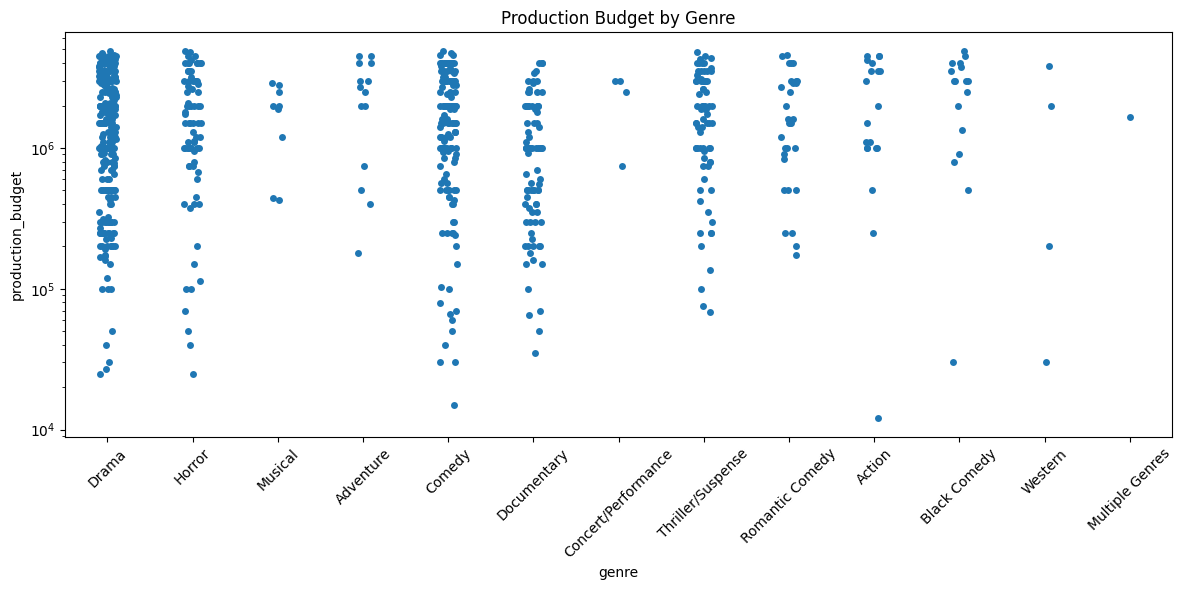

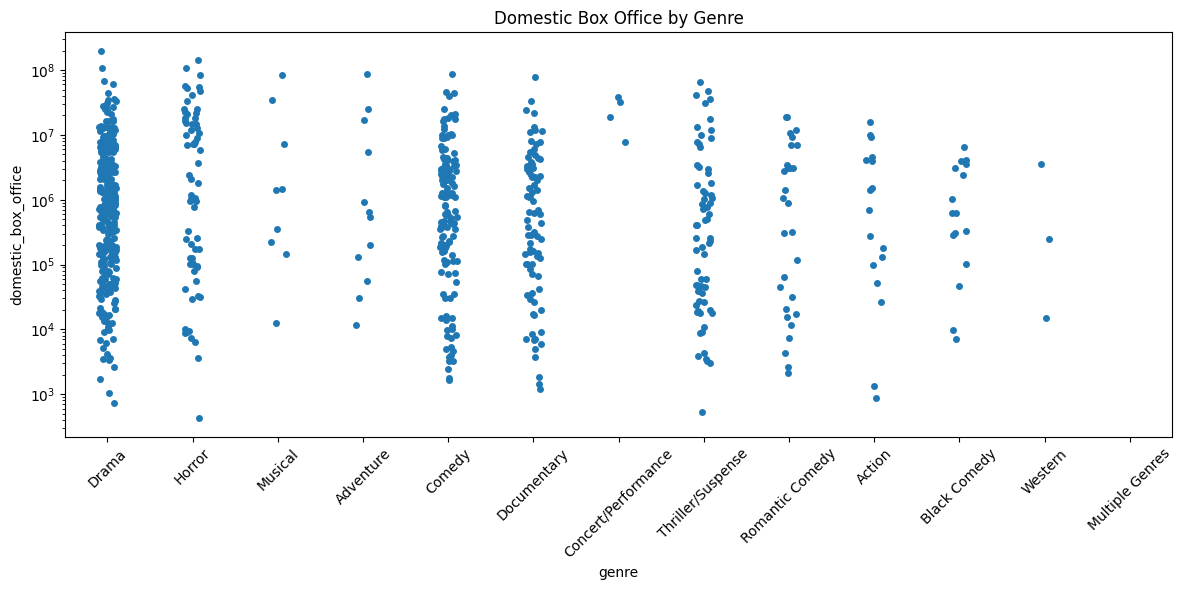

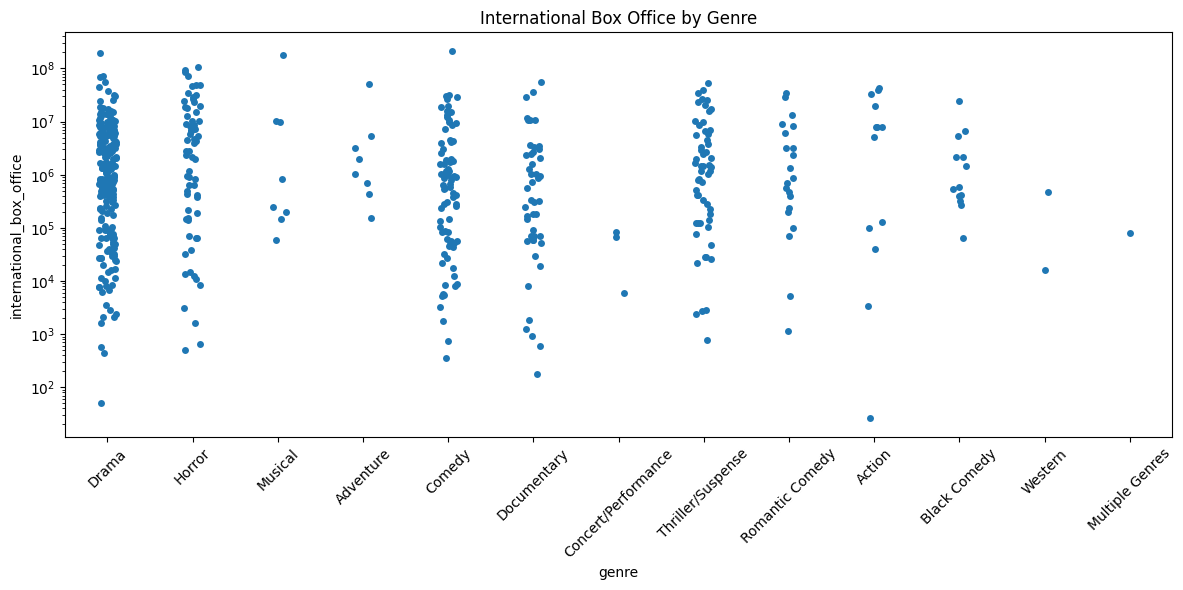

In [123]:
# Load data
df = pd.read_csv('movie_summary.csv')

# Filter by production year and budget
filtered_df = df[
    (df['genre'] != "Reality") &
    (df['production_budget'] < 5000000) &
    (df['production_budget'] > 10000) &
    df['genre'].notna() &
    df['domestic_box_office'].notna() &
    df['international_box_office'].notna()
]

print(filtered_df.size)

# Strip plot (with jitter to separate overlapping points)
plt.figure(figsize=(12, 6))
sns.stripplot(data=filtered_df, x='genre', y='production_budget', jitter=True)
plt.yscale('log')
plt.title("Production Budget by Genre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("budget_strip_plot")
plt.show()

plt.figure(figsize=(12, 6))
sns.stripplot(data=filtered_df, x='genre', y='domestic_box_office', jitter=True)
plt.yscale('log')
plt.title("Domestic Box Office by Genre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.stripplot(data=filtered_df, x='genre', y='international_box_office', jitter=True)
plt.yscale('log')
plt.title("International Box Office by Genre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

$$
\begin{aligned}
H_0: &\text{The box office of the movies of different genres are eqivalent.} \\
H_1: &\text{The box office of the movies of at least one genre is different from others.}
\end{aligned}
$$

In [124]:
# ---------------------------
# Shapiro-Wilk Normality Test (per genre group)
# ---------------------------
print("=== Shapiro-Wilk Test (Domestic Box Office per Genre) ===")
genre_groups = filtered_df.groupby('genre')['domestic_box_office']

for genre, values in genre_groups:
    if len(values) >= 3:  # Shapiro-Wilk requires at least 3 values
        stat, p = shapiro(values)
        print(f"Genre: {genre:<20} | W = {stat:.4f} | p = {p:.4f}")

# ---------------------------
# Bartlett's Test (Equal variances across genres)
# ---------------------------
# Collect lists of values per genre
grouped_values = [  group['domestic_box_office'].values 
                    for name, group in filtered_df.groupby('genre') 
                    if len(group) >= 3  ]

print("\n=== Bartlett's Test (Domestic Box Office across Genres) ===")
bartlett_stat, bartlett_p = bartlett(*grouped_values)
print(f"Bartlett's Test: stat = {bartlett_stat:.4f} | p = {bartlett_p:.4f}\n")

=== Shapiro-Wilk Test (Domestic Box Office per Genre) ===
Genre: Action               | W = 0.6682 | p = 0.0000
Genre: Adventure            | W = 0.4884 | p = 0.0000
Genre: Black Comedy         | W = 0.7926 | p = 0.0016
Genre: Comedy               | W = 0.4217 | p = 0.0000
Genre: Concert/Performance  | W = 0.9587 | p = 0.7709
Genre: Documentary          | W = 0.3775 | p = 0.0000
Genre: Drama                | W = 0.3005 | p = 0.0000
Genre: Horror               | W = 0.5514 | p = 0.0000
Genre: Musical              | W = 0.5955 | p = 0.0001
Genre: Romantic Comedy      | W = 0.6804 | p = 0.0000
Genre: Thriller/Suspense    | W = 0.4408 | p = 0.0000
Genre: Western              | W = 0.6802 | p = 0.0067

=== Bartlett's Test (Domestic Box Office across Genres) ===
Bartlett's Test: stat = 267.7584 | p = 0.0000



In [125]:
# Welch's ANOVA for domestic box office
print("=== Welch's ANOVA: Domestic Box Office ===")
welch_domestic = pg.welch_anova(dv='domestic_box_office', between='genre', data=filtered_df)
print(welch_domestic)

print("\n=== Welch's ANOVA: International Box Office ===")
welch_international = pg.welch_anova(dv='international_box_office', between='genre', data=filtered_df)
print(welch_international)

=== Welch's ANOVA: Domestic Box Office ===
  Source  ddof1      ddof2         F     p-unc       np2
0  genre     12  59.662234  3.363459  0.000883  0.042322

=== Welch's ANOVA: International Box Office ===
  Source  ddof1      ddof2         F         p-unc       np2
0  genre     12  78.674532  7.039331  1.643708e-08  0.038032



=== Tukey HSD: Domestic Box Office ===
Q critical value = 4.699636
Tukey Omega = 25741072.198598
                       Multiple Comparison of Means - Tukey HSD, FWER=0.05                       
       group1              group2          meandiff    p-adj      lower          upper     reject
-------------------------------------------------------------------------------------------------
             Action           Adventure   7182893.2786 0.9699  -9533085.1438 23898871.7009  False
             Action        Black Comedy  -1034546.7676    1.0 -16859147.5476 14790054.0123  False
             Action              Comedy   1446240.8432    1.0  -9982020.0004 12874501.6868  False
             Action Concert/Performance     21709689.6 0.2306  -4564660.7349 47984039.9349  False
             Action         Documentary    926976.7337    1.0 -10981605.7249 12835559.1923  False
             Action               Drama   2177752.3021    1.0  -8886098.4633 13241603.0675  False
             Action 

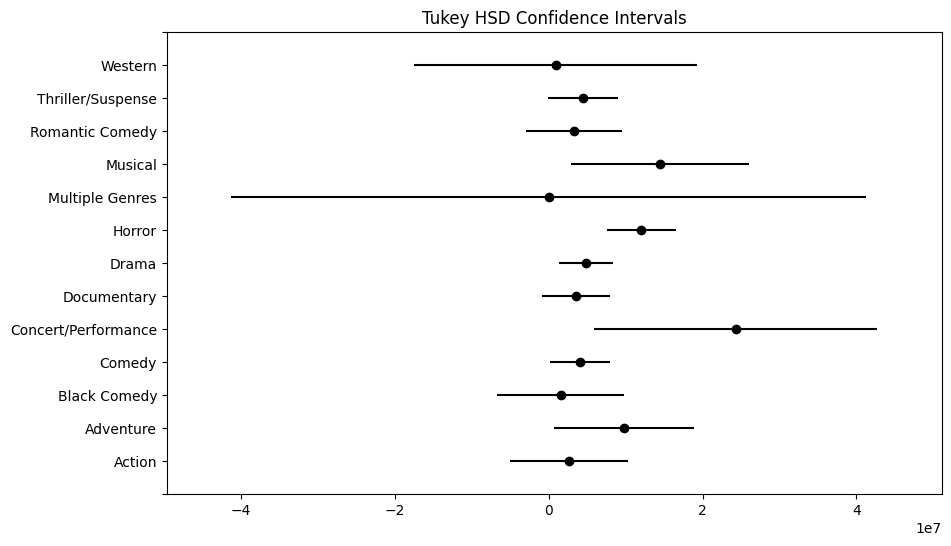


=== Tukey HSD: International Box Office ===
Q critical value = 4.699636
Tukey Omega = 27955803.424948
                       Multiple Comparison of Means - Tukey HSD, FWER=0.05                       
       group1              group2          meandiff    p-adj      lower          upper     reject
-------------------------------------------------------------------------------------------------
             Action           Adventure  -3587554.4071    1.0  -21741755.725 14566646.9107  False
             Action        Black Comedy  -5552884.8735 0.9975 -22739015.4772 11633245.7301  False
             Action              Comedy  -4639263.2189 0.9905 -17050798.0287  7772271.5908  False
             Action Concert/Performance    -8135010.05 0.9993 -36669974.2276 20399954.1276  False
             Action         Documentary    -5860674.05 0.9547  -18793856.775   7072508.675  False
             Action               Drama  -4417724.5644 0.9918 -16433495.8863  7598046.7576  False
             Ac

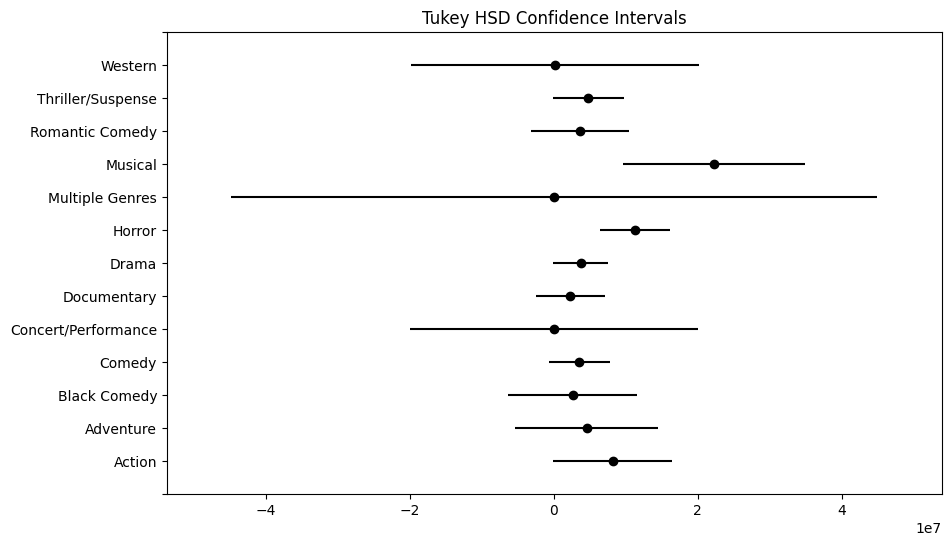

In [126]:
def tukey_hsd(df, response_col, factor_col, alpha=0.05, comparison_focus=None):
    group_sizes = df.groupby(factor_col).size()
    k = len(group_sizes)
    df_within = df.shape[0] - k

    ng = k / np.sum(1 / group_sizes)

    model = smf.ols(f"{response_col} ~ C({factor_col})", data=df).fit()
    aov_table = sms.anova_lm(model, typ=2)
    mse = aov_table.loc["Residual", "sum_sq"] / aov_table.loc["Residual", "df"]

    q_crit = qsturng(1 - alpha, k, df_within)
    omega = q_crit * np.sqrt(mse / ng)

    tukey = MultiComparison(df[response_col], df[factor_col])
    tukey_result = tukey.tukeyhsd(alpha=alpha)

    print(f"Q critical value = {q_crit:.6f}")
    print(f"Tukey Omega = {omega:.6f}")
    print(tukey_result.summary())

    # Plot overall CI
    _ = tukey_result.plot_simultaneous()
    plt.title("Tukey HSD Confidence Intervals")
    plt.show()

    # Optional: Focused plot on a specific group
    if comparison_focus:
        _ = tukey_result.plot_simultaneous(comparison_name=comparison_focus)
        plt.title(f"Tukey HSD Focused on: {comparison_focus}")
        plt.show()

    return tukey_result.summary(), omega

# Run Tukey HSD for domestic box office
print("\n=== Tukey HSD: Domestic Box Office ===")
summary_dom, omega_dom = tukey_hsd(filtered_df, 'domestic_box_office', 'genre')

# Run Tukey HSD for international box office
print("\n=== Tukey HSD: International Box Office ===")
summary_intl, omega_intl = tukey_hsd(filtered_df, 'international_box_office', 'genre')

In [127]:
# ---------------------------
# Shapiro-Wilk Normality Test (per genre group)
# ---------------------------
print("=== Shapiro-Wilk Test (Domestic Box Office per Genre) ===")
genre_groups = filtered_df.groupby('genre')['production_budget']

for genre, values in genre_groups:
    if len(values) >= 3:  # Shapiro-Wilk requires at least 3 values
        stat, p = shapiro(values)
        print(f"Genre: {genre:<20} | W = {stat:.4f} | p = {p:.4f}")

# ---------------------------
# Bartlett's Test (Equal variances across genres)
# ---------------------------
# Collect lists of values per genre
grouped_values = [  group['production_budget'].values 
                    for name, group in filtered_df.groupby('genre') 
                    if len(group) >= 3  ]

print("\n=== Bartlett's Test (Domestic Box Office across Genres) ===")
bartlett_stat, bartlett_p = bartlett(*grouped_values)
print(f"Bartlett's Test: stat = {bartlett_stat:.4f} | p = {bartlett_p:.4f}\n")

=== Shapiro-Wilk Test (Domestic Box Office per Genre) ===
Genre: Action               | W = 0.8734 | p = 0.0135
Genre: Adventure            | W = 0.9181 | p = 0.2064
Genre: Black Comedy         | W = 0.9460 | p = 0.3968
Genre: Comedy               | W = 0.9333 | p = 0.0000
Genre: Concert/Performance  | W = 0.7760 | p = 0.0657
Genre: Documentary          | W = 0.8682 | p = 0.0000
Genre: Drama                | W = 0.9263 | p = 0.0000
Genre: Horror               | W = 0.9285 | p = 0.0003
Genre: Musical              | W = 0.8999 | p = 0.2513
Genre: Romantic Comedy      | W = 0.9144 | p = 0.0168
Genre: Thriller/Suspense    | W = 0.9433 | p = 0.0024
Genre: Western              | W = 0.8896 | p = 0.3815

=== Bartlett's Test (Domestic Box Office across Genres) ===
Bartlett's Test: stat = 20.2572 | p = 0.0419



In [128]:
# Welch's ANOVA for production budget
print("=== Welch's ANOVA: Domestic Box Office ===")
welch_domestic = pg.welch_anova(dv='production_budget', between='genre', data=filtered_df)
print(welch_domestic)

=== Welch's ANOVA: Domestic Box Office ===
  Source  ddof1      ddof2         F     p-unc       np2
0  genre     12  54.236096  3.288213  0.001286  0.041269



=== Tukey HSD: Domestic Box Office ===
Q critical value = 4.699636
Tukey Omega = 2392782.832871
                     Multiple Comparison of Means - Tukey HSD, FWER=0.05                      
       group1              group2          meandiff   p-adj      lower        upper     reject
----------------------------------------------------------------------------------------------
             Action           Adventure   147614.2857    1.0 -1406233.4287 1701462.0002  False
             Action        Black Comedy   348076.4706 0.9999 -1122912.4918 1819065.4329  False
             Action              Comedy  -390012.1622 0.9919 -1452335.6794  672311.3551  False
             Action Concert/Performance       29400.0    1.0 -2412954.1468 2471754.1468  False
             Action         Documentary -1097832.5581 0.0544 -2204804.7717    9139.6554  False
             Action               Drama  -361997.7636 0.9945 -1390447.2381   666451.711  False
             Action              Horror  -371292

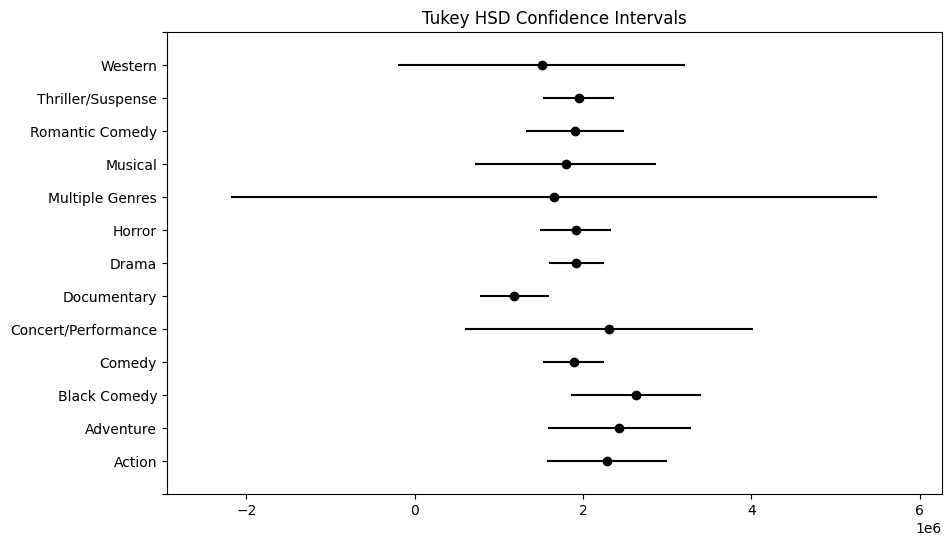

In [129]:
# Run Tukey HSD for domestic box office
print("\n=== Tukey HSD: Domestic Box Office ===")
summary_bgt, omega_bgt = tukey_hsd(filtered_df, 'production_budget', 'genre')